# Human-AI Image Detection Model Training

This notebook implements the training pipeline for detecting AI-generated vs human-created images.

In [1]:
%load_ext autoreload
%autoreload 2

import yaml
import torch
import mlflow
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.model_factory import ModelFactory
from src.data.human_ai_dataset import HumanVSAIDataset
from src.training.trainer import ModelTrainer

## Configuration

In [2]:
%load_ext autoreload
%autoreload 2

def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

config = load_config('config/config.yaml')
print("Loaded configuration:")
print(yaml.dump(config, default_flow_style=False))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded configuration:
dataset:
  test_csv: dataset/test.csv
  test_path: dataset/test_data_v2
  test_split: 0.3
  train_csv: dataset/train.csv
  train_path: dataset/train_data
hyperparameter_search:
  batch_size:
  - 32
  - 64
  - 128
  learning_rate:
  - 0.001
  - 0.01
  - 0.1
model_names:
- deep_cnn
models:
  deep_cnn:
    base_params:
      in_channels_list:
      - 3
      - 32
      - 64
      - 128
      kernel_size_list:
      - 3
      - 3
      - 3
      - 3
      out_channels_list:
      - 32
      - 64
      - 128
      - 256
    parameter_search:
      dropout_rate:
      - 0.7
      - 0.5
      - 0.3
training:
  cross_validation:
    n_splits: 5
    shuffle: true
  early_stopping:
    min_delta: 0.001
    patience: 10
  epochs: 3
  eval_interval: 5
  optimizer:
    name: adam
    params:
      weight_decay: 0.01



## Data Loading and Preprocessing

In [12]:
import torch.utils
import torch.utils.data


labels_map = {
    0: 'Human generated',
    1: 'AI generated'
}

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

dataset = HumanVSAIDataset(
    annotations_file_path=config['dataset']['train_csv'],
    transform=transform
)

trainset_size = 1 - config['dataset']['test_split']
trainset_size = int(len(dataset) * trainset_size)
valset_size = int(len(dataset) - trainset_size)

trainset, valset = torch.utils.data.random_split(dataset, [trainset_size, valset_size])

print(f"Total trainset size: {len(dataset)}")
print(f"Training dataset size: {len(trainset)}")
print(f"Validation dataset size: {len(valset)}")

trainloader = torch.utils.data.DataLoader(trainset)

Total trainset size: 79950
Training dataset size: 55965
Validation dataset size: 23985


In [13]:
image, label = dataset[101]
label

0

## Visualize Sample Images

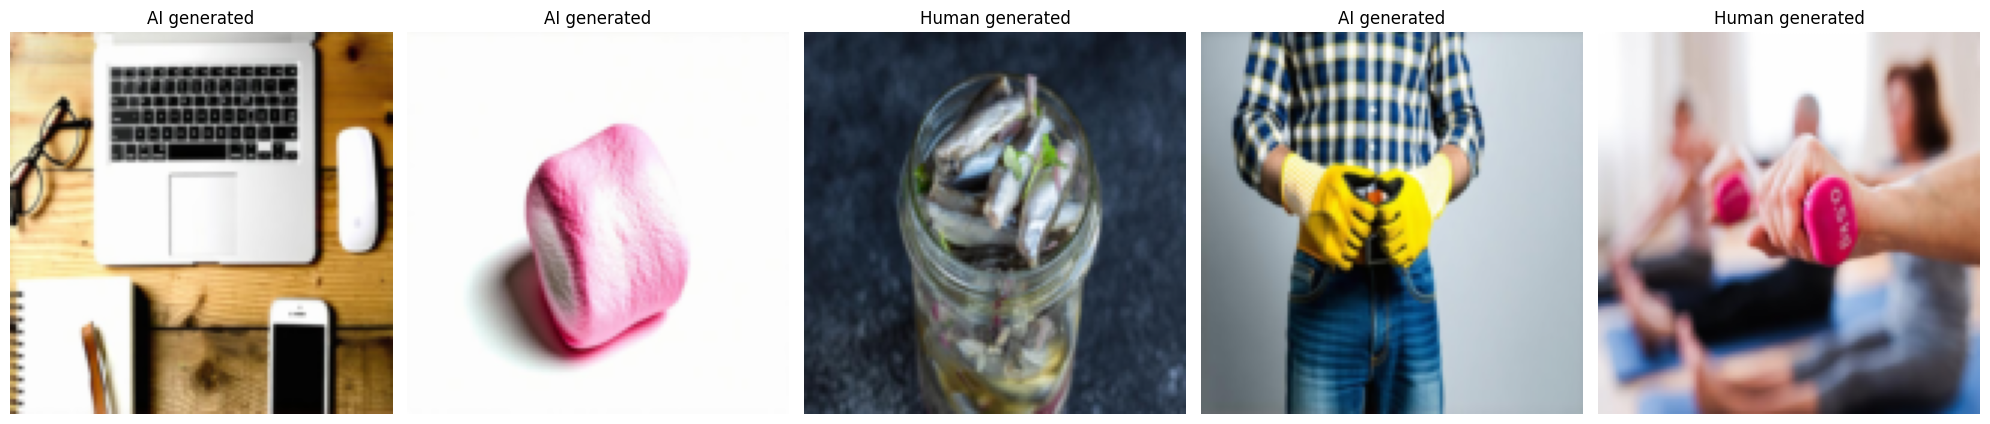

In [14]:
def show_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        img, label = dataset[i]


        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy() 

        img = (img - img.min()) / (img.max() - img.min())
        axes[i].imshow(img)
        axes[i].set_title(labels_map[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(trainset)

## Model Training and Hyperparameter Tuning

In [15]:
import torch.utils.data.dataset
import random

trainset_size = len(trainset)
indices = random.sample(range(trainset_size), 100)
trainset = torch.utils.data.dataset.Subset(trainset, indices)

In [16]:
model_factory = ModelFactory()
trainer = ModelTrainer(config, model_factory)

# Perform hyperparameter tuning
best_params, best_score = trainer.train_and_tune(trainset)

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Training deep_cnn
Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.7, 'learning_rate': 0.001}
Performing KFold Cross Validation with 5 folds
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s, loss=0.733, acc=45]  


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s, loss=0.74, acc=45]   


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s, loss=0.74, acc=45]   


Accuracy obtained on Fold 1: 9.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s, loss=0.74, acc=46.2] 


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s, loss=0.728, acc=46.2]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  4.17it/s, loss=0.706, acc=46.2]


Accuracy obtained on Fold 2: 10.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  4.19it/s, loss=0.697, acc=51.2]


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s, loss=0.686, acc=51.2]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s, loss=0.674, acc=51.2]


Accuracy obtained on Fold 3: 14.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s, loss=0.717, acc=43.8]


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s, loss=0.652, acc=43.8]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s, loss=0.675, acc=45]  


Accuracy obtained on Fold 4: 8.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s, loss=0.679, acc=48.8]


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s, loss=0.66, acc=48.8] 


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s, loss=0.627, acc=50]  


Accuracy obtained on Fold 5: 12.0
Mean score obtained from KFold: 10.6
Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.7, 'learning_rate': 0.01}
Performing KFold Cross Validation with 5 folds
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s, loss=0.824, acc=43.8]


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s, loss=0.727, acc=45]  


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s, loss=0.715, acc=52.5]


Accuracy obtained on Fold 1: 9.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s, loss=0.728, acc=50]  


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s, loss=0.689, acc=53.8]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s, loss=0.734, acc=46.2]


Accuracy obtained on Fold 2: 11.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s, loss=0.726, acc=46.2]


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s, loss=0.684, acc=53.8]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s, loss=0.721, acc=46.2]


Accuracy obtained on Fold 3: 13.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s, loss=0.725, acc=45]  


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s, loss=0.703, acc=53.8]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s, loss=0.72, acc=50]   


Accuracy obtained on Fold 4: 13.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s, loss=0.724, acc=55]  


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s, loss=0.73, acc=55]   


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s, loss=0.739, acc=53.8]


Accuracy obtained on Fold 5: 7.0
Mean score obtained from KFold: 10.6
Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.7, 'learning_rate': 0.1}
Performing KFold Cross Validation with 5 folds
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s, loss=0.816, acc=50]  


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s, loss=0.795, acc=47.5]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s, loss=0.773, acc=51.2]


Accuracy obtained on Fold 1: 12.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s, loss=0.809, acc=46.2]


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s, loss=0.746, acc=58.8]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s, loss=0.774, acc=50]  


Accuracy obtained on Fold 2: 14.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s, loss=0.847, acc=43.8]


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s, loss=0.794, acc=53.8]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s, loss=0.844, acc=47.5]


Accuracy obtained on Fold 3: 9.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s, loss=0.795, acc=48.8]


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s, loss=0.815, acc=46.2]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s, loss=0.773, acc=51.2]


Accuracy obtained on Fold 4: 9.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s, loss=0.865, acc=45]  


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s, loss=0.781, acc=53.8]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s, loss=0.816, acc=45]  


Accuracy obtained on Fold 5: 9.0
Mean score obtained from KFold: 10.6
Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001}
Performing KFold Cross Validation with 5 folds
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s, loss=0.74, acc=50]   


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s, loss=0.711, acc=50]  


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s, loss=0.686, acc=50]  


Accuracy obtained on Fold 1: 13.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s, loss=0.696, acc=47.5]


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.60it/s, loss=0.688, acc=51.2]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s, loss=0.675, acc=47.5]


Accuracy obtained on Fold 2: 11.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s, loss=0.674, acc=48.8]


Epoch 2


Training: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s, loss=0.663, acc=47.5]


Epoch 3


Training: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s, loss=0.654, acc=51.2]


Accuracy obtained on Fold 3: 11.0
Epoch 1


Training: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s, loss=0.647, acc=60]  


Epoch 2


Training:   0%|          | 0/3 [00:00<?, ?it/s]


KeyboardInterrupt: 

## Training Visualization

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_loss'], label='Train')
    ax1.plot(history['val_loss'], label='Validation')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history['train_acc'], label='Train')
    ax2.plot(history['val_acc'], label='Validation')
    ax2.set_title('Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(trainer.history)

## Save Best Model

In [ ]:
# Train final model with best parameters
final_model = model_factory.get_model(
    config['model']['name'],
    **{**config['model']['base_params'], **best_params}
)

# Save best model
save_path = 'models/best_model.pt'
torch.save({
    'model_state_dict': final_model.state_dict(),
    'best_params': best_params,
    'best_score': best_score
}, save_path)

print(f"Model saved to {save_path}")